Code based on: https://sorenbouma.github.io/blog/oneshot/ and https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb

In [2]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.losses import binary_crossentropy
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Siamese Network architecture
We define a Siamese Network for use with the Omniglot dataset. The architecture is similar to that in the paper (Koch et al., "Siamese Neural Networks for One-shot Image Recognition"), but we include dropout and batch normalization to improve generalization and speed up training.

Each siamese "leg" is a convnet that transforms data to a 4096-dimensional representation. The metric we are trying to learn is the L1-distance between such representations. The output of the full Siamese Network represents the probability that the two input images are "similar" (in this case: of the same class).

In [3]:
input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 64)        6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 21, 128)       512       
__________

# Omniglot Data
We pickled the Omniglot dataset with the "Practical-4.2.0_preprocess-omniglot.ipynb" notebook, as an array of shape (n_classes x n_examples x width x height), and there is an accompanying dictionary to specify which indexes belong to which languages. Let's load this data now.

In [4]:
PATH = os.path.join("data", "omniglot")

with open(os.path.join(PATH, "omniglot_train.p"), "rb") as f:
    (X_train, c_train) = pickle.load(f)

with open(os.path.join(PATH, "omniglot_test.p"), "rb") as f:
    (X_test, c_test) = pickle.load(f)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("")
print("training alphabets")
print([key for key in c_train.keys()])
print("test alphabets:")
print([key for key in c_test.keys()])

c_train

X_train shape: (964, 20, 105, 105)
X_test shape: (659, 20, 105, 105)

training alphabets
['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']
test alphabets:
['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


{'Alphabet_of_the_Magi': [0, 19],
 'Anglo-Saxon_Futhorc': [20, 48],
 'Arcadian': [49, 74],
 'Armenian': [75, 115],
 'Asomtavruli_(Georgian)': [116, 155],
 'Balinese': [156, 179],
 'Bengali': [180, 225],
 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [226, 239],
 'Braille': [240, 265],
 'Burmese_(Myanmar)': [266, 299],
 'Cyrillic': [300, 332],
 'Early_Aramaic': [333, 354],
 'Futurama': [355, 380],
 'Grantha': [381, 423],
 'Greek': [424, 447],
 'Gujarati': [448, 495],
 'Hebrew': [496, 517],
 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [518, 533],
 'Japanese_(hiragana)': [534, 585],
 'Japanese_(katakana)': [586, 632],
 'Korean': [633, 672],
 'Latin': [673, 698],
 'Malay_(Jawi_-_Arabic)': [699, 738],
 'Mkhedruli_(Georgian)': [739, 779],
 'N_Ko': [780, 812],
 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [813, 826],
 'Sanskrit': [827, 868],
 'Syriac_(Estrangelo)': [869, 891],
 'Tagalog': [892, 908],
 'Tifinagh': [909, 963]}

Notice that the training set contains 964 different characters, each belonging to one of 30 languages/scripts. The test set contains 659 different characters, each belonging to one of 20 languages/scripts. Each class (character) has only 20 examples, thus training a classifier on them would likely severely overfit.

# Training functions
To be able to train the Siamese Network we need to do a bit more work than for a simple classification network. We cannot simply feed the full dataset into the network batch by batch, instead here we need pairs of examples. These should be positive examples (where both images are from the same class, with a target output of 1) and negative examples (where the two input images are from a different class, with a target output of 0).

To achieve this, we define the "get_batch" function which selects a number of pairs, half of them with images from the same class, and half of them with images from two different classes.

We also define a generator function "batch_generator" that will repeatedly generate batches using "get_batch", such that we can use it for training with Keras's "fit_generator" method.

In [5]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, 1)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

# One-shot functions
The paper aims at using Siamese Networks for N-way One-shot Image Recognition. In this scenario, N examples of reference images are given, each belonging to a different class, as well as a test image that corresponds to exactly one of these classes. The task is to correctly classify which class the test image belongs to, given only one example from each of the N classes.

We define a function "make_oneshot_task" that can randomly setup such a one-shot task from a given test set (if a language is specified, using only classes/characters from that language), i.e. it will generate N pairs of images, where the first image is always the test image, and the second image is one of the N reference images. The pair of images from the same class will have target 1, all other targets are 0.

The function "test_oneshot" will generate a number (k) of such one-shot tasks and evaluate the performance of a given model on these tasks; it reports the percentage of correctly classified test images.

In [6]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    if language is not None:
        low, high = c[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = np.random.choice(range(low,high), size=(N,), replace=False)
    else:  # if no language specified just pick a bunch of random letters
        categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, 1)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, c, N=20, k=250, language=None, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c, language=language)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

## Plotting example one-shot tasks
Let's visualize some one-shot tasks to get an idea of how well humans can solve such tasks.

In [7]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

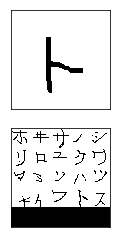

In [8]:
pairs, targets = make_oneshot_task(20, X_train, c_train, language="Japanese_(katakana)")
plot_oneshot_task(pairs)

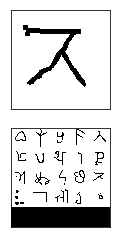

In [9]:
pairs, targets = make_oneshot_task(20, X_train, c_train)
plot_oneshot_task(pairs)

# Training
Let's train the model now. In each training loop, we sample 100 batches of 64 image pairs (as specified in the "train" method above), after which we evaluate the one-shot image recognition accuracy of the model. Whenever the model achieves a new best accuracy, we save its weights to a file (note that we do not directly use the value of the loss function).

*NOTE: training may take a long time, especially if training on CPU*

In [10]:
loops = 200
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, X_train)
    test_acc = test_oneshot(siamese_net, X_test, c_test)
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        siamese_net.save(os.path.join("models", "siamese_omniglot.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 76s 764ms/step - loss: 5.6446
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 21.6% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 68s 685ms/step - loss: 1.7219
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 29.2% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 3 ===
Epoch 1/1
100/100 [==============================] - 69s 687ms/step - loss: 1.3847
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 31.2% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 69s 686ms/step - loss: 1.3284
Evaluating model on 250 random 20-way one-shot learni

Got an average of 53.6% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 34 ===
Epoch 1/1
100/100 [==============================] - 70s 700ms/step - loss: 1.1600
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 59.2% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 35 ===
Epoch 1/1
100/100 [==============================] - 70s 699ms/step - loss: 1.1737
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 44.8% accuracy for 20-way one-shot learning
=== Training loop 36 ===
Epoch 1/1
100/100 [==============================] - 70s 700ms/step - loss: 1.1626
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 50.8% accuracy for 20-way one-shot learning
=== Training loop 37 ===
Epoch 1/1
100/100 [==============================] - 71s 706ms/step - loss: 1.1191
Evaluating model on 250 random 2

Got an average of 55.6% accuracy for 20-way one-shot learning
=== Training loop 67 ===
Epoch 1/1
100/100 [==============================] - 70s 702ms/step - loss: 0.7220
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 53.6% accuracy for 20-way one-shot learning
=== Training loop 68 ===
Epoch 1/1
100/100 [==============================] - 70s 702ms/step - loss: 0.7643
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 65.6% accuracy for 20-way one-shot learning
=== Training loop 69 ===
Epoch 1/1
100/100 [==============================] - 70s 696ms/step - loss: 0.7664
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 64.8% accuracy for 20-way one-shot learning
=== Training loop 70 ===
Epoch 1/1
100/100 [==============================] - 70s 701ms/step - loss: 0.7494
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 63.2% accuracy for 20-way one-shot lea

Got an average of 70.0% accuracy for 20-way one-shot learning
=== Training loop 101 ===
Epoch 1/1
100/100 [==============================] - 70s 697ms/step - loss: 0.6395
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 33.2% accuracy for 20-way one-shot learning
=== Training loop 102 ===
Epoch 1/1
100/100 [==============================] - 70s 700ms/step - loss: 0.6163
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 61.6% accuracy for 20-way one-shot learning
=== Training loop 103 ===
Epoch 1/1
100/100 [==============================] - 71s 706ms/step - loss: 0.5805
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 35.2% accuracy for 20-way one-shot learning
=== Training loop 104 ===
Epoch 1/1
100/100 [==============================] - 70s 701ms/step - loss: 0.5680
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 45.6% accuracy for 20-way one-shot

Got an average of 31.6% accuracy for 20-way one-shot learning
=== Training loop 135 ===
Epoch 1/1
100/100 [==============================] - 70s 699ms/step - loss: 0.4684
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 79.2% accuracy for 20-way one-shot learning
=== Training loop 136 ===
Epoch 1/1
100/100 [==============================] - 70s 702ms/step - loss: 0.4408
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 82.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 137 ===
Epoch 1/1
100/100 [==============================] - 70s 696ms/step - loss: 0.4262
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 82.4% accuracy for 20-way one-shot learning
=== Training loop 138 ===
Epoch 1/1
100/100 [==============================] - 70s 696ms/step - loss: 0.4457
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an 